In [5]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(17)
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [8]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [9]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [46]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [47]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [48]:
batch_size = 16

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 176
Number of test batches 6


In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [89]:
# Data Visualization

class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 16, i + 1, xticks=[], yticks=[])
        image = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        labels = labels.cpu()
        preds = preds.cpu()
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

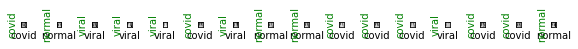

In [90]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

In [91]:
# Model
resnet18 = torchvision.models.resnet18(pretrained=True)

In [92]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [93]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    images, labels = images.to('cuda:0'), labels.to('cuda:0')
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

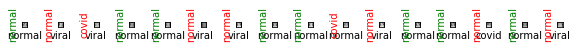

model to device


In [94]:
# predictions without finetuning
resnet18.to(device)
show_preds()
print('model to device')

In [97]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                accuracy = 0
                resnet18.eval()     # setting to eval mode

                for val_step, (images, labels) in enumerate(dl_test):
                    images, labels = images.cuda(), labels.cuda()
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.3f}, Accuracy: {accuracy:.3f}')

                show_preds()
                resnet18.train()    # setting back to training mode

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.3f}')
    print('Training complete..')

Starting training..
Starting epoch 1/2
Evaluating at step 0
Validation Loss: 1.135, Accuracy: 0.433


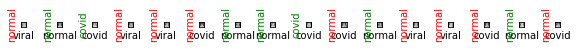

Evaluating at step 20
Validation Loss: 0.774, Accuracy: 0.778


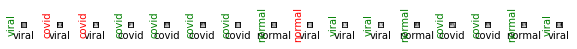

Evaluating at step 40
Validation Loss: 0.391, Accuracy: 0.922


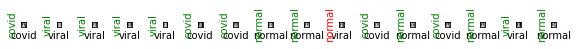

Evaluating at step 60
Validation Loss: 0.168, Accuracy: 0.956


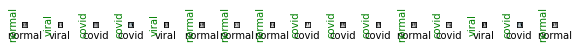

Evaluating at step 80
Validation Loss: 0.144, Accuracy: 0.944


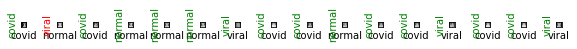

Evaluating at step 100
Validation Loss: 0.093, Accuracy: 0.967


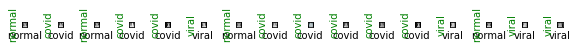

Evaluating at step 120
Validation Loss: 0.118, Accuracy: 0.956


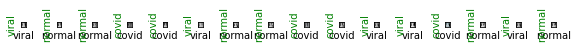

Evaluating at step 140
Validation Loss: 0.080, Accuracy: 0.978


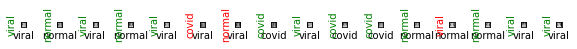

Evaluating at step 160
Validation Loss: 0.103, Accuracy: 0.967


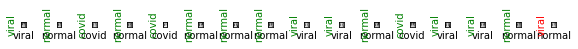

Training Loss: 0.222
Starting epoch 2/2
Evaluating at step 0
Validation Loss: 0.103, Accuracy: 0.956


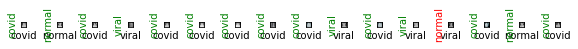

Evaluating at step 20
Validation Loss: 0.132, Accuracy: 0.944


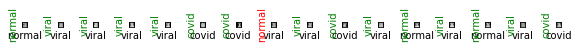

Evaluating at step 40
Validation Loss: 0.124, Accuracy: 0.967


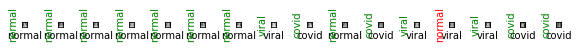

Evaluating at step 60
Validation Loss: 0.116, Accuracy: 0.967


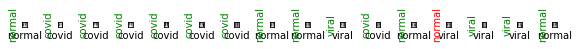

Evaluating at step 80
Validation Loss: 0.099, Accuracy: 0.933


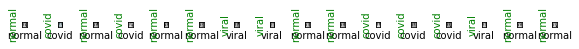

Evaluating at step 100
Validation Loss: 0.111, Accuracy: 0.956


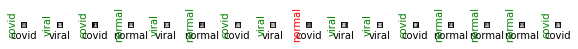

Evaluating at step 120
Validation Loss: 0.046, Accuracy: 1.000


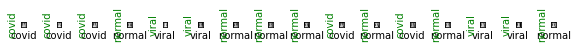

Evaluating at step 140
Validation Loss: 0.044, Accuracy: 0.989


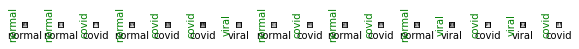

Evaluating at step 160
Validation Loss: 0.076, Accuracy: 0.978


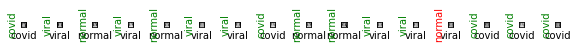

Training Loss: 0.070
Training complete..
CPU times: user 3min 57s, sys: 1.82 s, total: 3min 59s
Wall time: 4min


In [98]:
%%time

train(epochs=2)

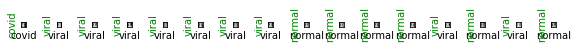

In [99]:
show_preds()